##Amruta Mahendra Parulekar 20D070009
##Keshav Singhal 20D070047
##Sameep Chattopadhyay 20d070067

In [ ]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.3/735.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does no

/usr/local/lib/python3.8/dist-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [ ]:
from IPython.display import Audio

## PyTorch things
import torch
import torchaudio
import torch.nn.functional as F

## Other libs
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm import tqdm_notebook
import torchsummary
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w[2:] not in excludes] #Edited line to get correct training set, Keshav



# Create training and testing split of the data. We do not use validation in this tutorial.
train_set_init = SubsetSC("training")
test_set_init = SubsetSC("testing")



In [ ]:
import urllib.request as req
data_test = req.urlopen(r"https://www.cse.iitb.ac.in/~pjyothi/cs753/test_list.txt")
n_test=[]
for num in data_test:
  n_test.append(int(num))

In [ ]:
test_set=list([test_set_init[n] for n in n_test])

In [ ]:
print(len(test_set))

4000


In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = test_set[-1]
print(sample_rate)
print(label)
print(utterance_number)
print(speaker_id)

16000
four
3
b97c9f77


In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in test_set)))

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "bed"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

bed --> tensor(1) --> bed


In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False


test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=len(test_set), #Workaround, Keshav
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

In [ ]:
classes = sorted(list(set(datapoint[2] for datapoint in test_set)))
len(classes)

35

In [ ]:
class M11(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=64):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)

        self.conv6 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(4 * n_channel)
        self.conv7 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(4 * n_channel)
        self.conv8 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4)

        self.conv9 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(8 * n_channel)
        self.conv10 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(8 * n_channel)

        self.fc1 = nn.Linear(8 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool2(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool3(x)

        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = self.pool4(x)

        x = self.conv9(x)
        x = F.relu(self.bn9(x))
        x = self.conv10(x)
        x = F.relu(self.bn10(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('M11 model')
model_M11= M11(n_input=transformed.shape[0], n_output=len(labels))
model_M11.to(device)
print(model_M11)



n = count_parameters(model_M11)
print("Number of parameters: %s" % n)

M11 model
M11(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(

In [ ]:
model = model_M11
model_save_name = 'M11.pt'
path = "/content/drive/My Drive/M11.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def test(model, epoch):
    model.eval()
    correct = 0
    #i = 0
    for data, target in test_loader:
        #print(i)
        #i = i+1
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        #show_confusion_matrix(pred, target, classes)
        return pred,target

In [ ]:
#load saved dataset

def show_confusion_matrix(pred, Y_TEST, classes):

  pred = pred.cpu() #Saving tensor in CPU memory
  Y_TEST = Y_TEST.cpu()
  cm = confusion_matrix(Y_TEST,pred)
  cm = normalize(cm,axis=1,norm='l1')

  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  #df_cm = pd.DataFrame(cm, index = classes[0:24], columns = classes[0:24])
  #df_cm = pd.DataFrame(cm)

  plt.figure(figsize=(30,15))

  cmap = sn.cubehelix_palette(light=1, as_cmap=True)
  sn.heatmap(df_cm, annot=True,cmap=cmap)
  plt.title('Confusion Matrix',fontdict={'fontsize':20})
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show

In [ ]:
def find_confusion_matrix(model):
  n_epoch = 20
  #transform = transform.to(device)
  with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
      pred,target = test(model, epoch)
  show_confusion_matrix(pred, target, classes)

  0%|          | 0/20 [00:02<?, ?it/s]


TypeError: ignored

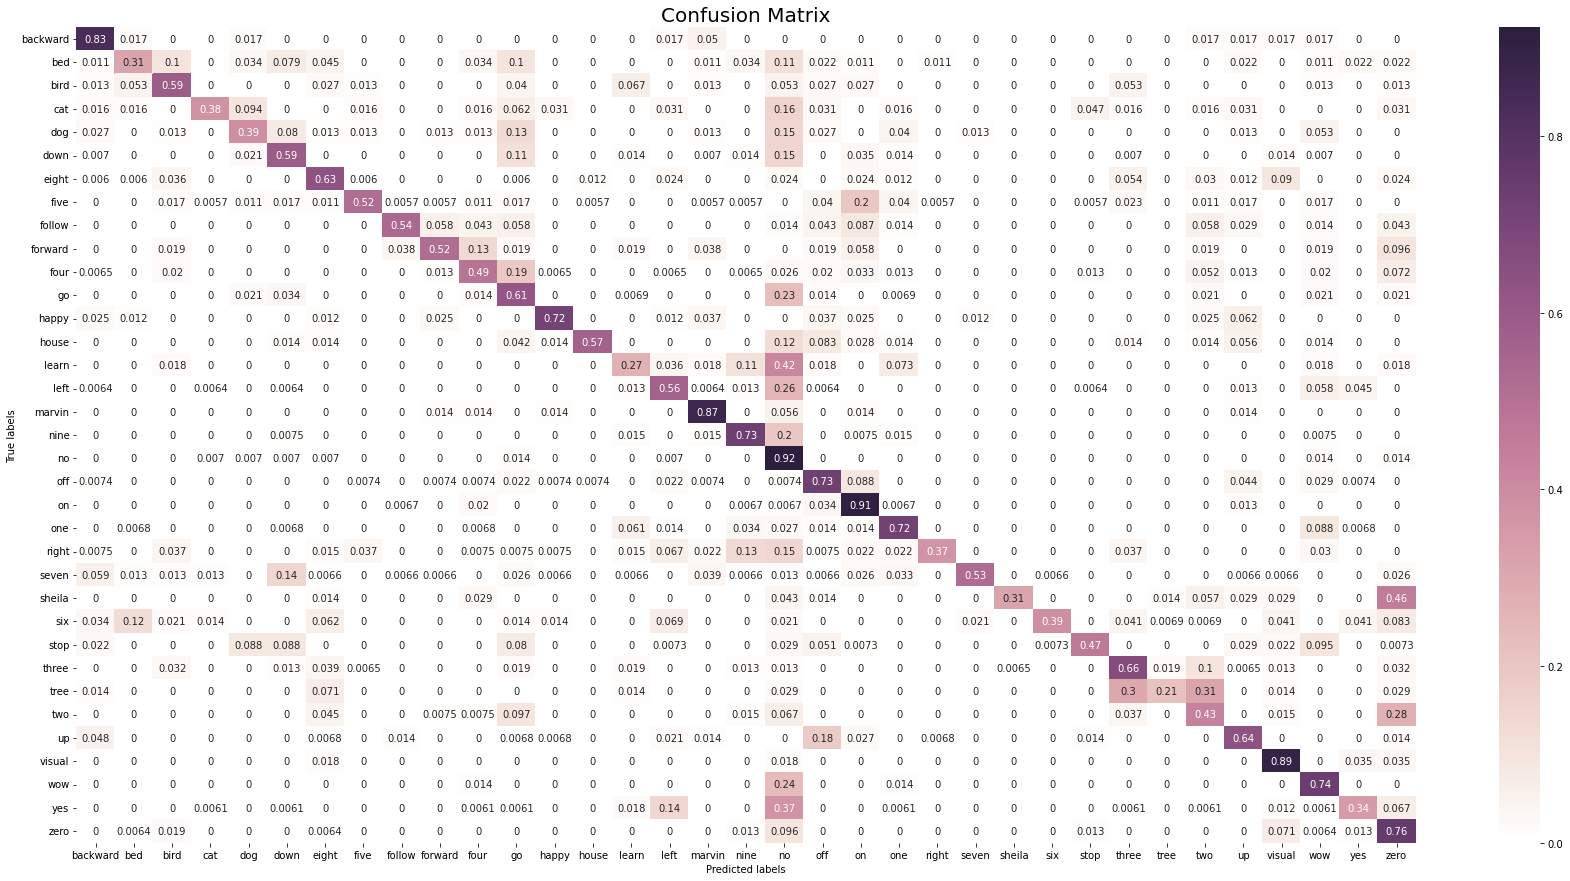

In [ ]:
find_confusion_matrix(model)